In [1]:
from glob import glob
import os
from os.path import basename, splitext
import pandas as pd
from datetime import datetime
from pytz import timezone
import shapefile
import numpy as np
import pickle

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# parameters
sf_path = "../data/akl_points.shp"
tz = timezone("Pacific/Auckland")

In [3]:
# shapefile
points = shapefile.Reader(sf_path)
npt = len(points.records())
print(f"Loaded shapefile with {npt} points")

# load precomputed odt
with open("../data/odt.npy", 'rb') as f:
    odt = np.load(f)
    print(f"loaded odt cube with dimensions {odt.shape}")
    
# load location index
with open("../data/loc_idx.pkl", 'rb') as f:
    loc_idx = pickle.load(f)
    print(f"loaded location index with dimension {len(loc_idx)}")

# load time index
with open("../data/t_idx.pkl", 'rb') as f:
    t_idx = pickle.load(f)
    print(f"loaded time index with dimension {len(t_idx)}")

Loaded shapefile with 2011 points
loaded odt cube with dimensions (2011, 2011, 2)
loaded location index with dimension 2011
loaded time index with dimension 2


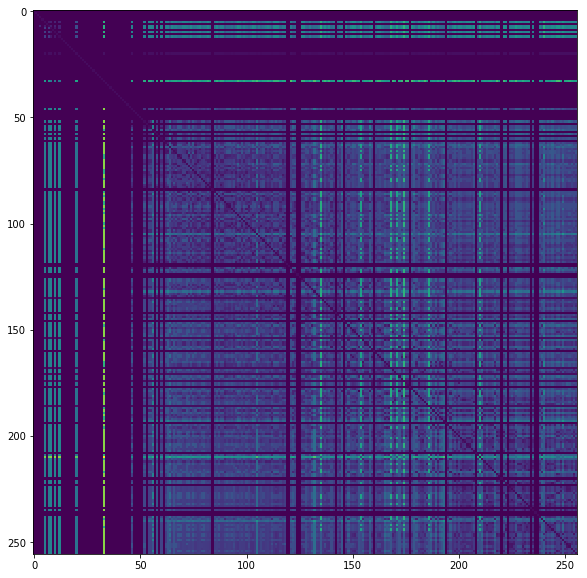

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(odt[:256, :256, 0]/odt.max())
plt.show()

In [ ]:
# make pseudo-odt cube by replicating timeslices
podt = np.tile(odt[:, :, 0].reshape(npt, npt, 1), (1, 1, 10))
print(podt.shape)

In [5]:
def is_valid(a, threshold=0):
    """
    a: np.array  
    return mask indicating columns in a include values > threshold
    """
    return a.max(axis=-1) > threshold

### All locations L accessible within M minutes of a known location L1

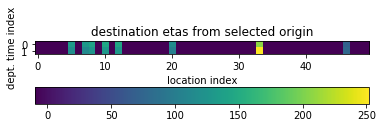

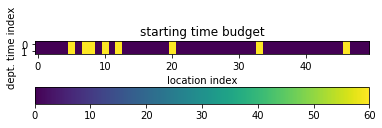

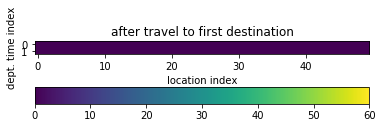

In [18]:
cube = odt # cube
l_idx = 0 # current location index in itinerary
origins = [676]
origin = origins[l_idx]
options = cube[origin, ...] # vertical plane through cube
valid = is_valid(options)

# initial route etas
plt.figure()
plt.imshow(np.transpose(options[:50, :]))
plt.title("destination etas from selected origin")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()

# set time budget for each option
t_budget = 60 # minutes

# list the time spent in minutes at each destination
t_dest = [60, 30]

t_remain = np.zeros_like(options)
t_remain[valid] = t_budget

plt.figure()
plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
plt.title("starting time budget")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()

# travel from origin to destination
t_remain[valid] -= options[valid]
t_remain[t_remain < 0] = 0

# update valid routes
valid = is_valid(t_remain)

plt.figure()
plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
plt.title("after travel to first destination")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()

# list of accessible location indices
acc_idx = [i for i, v in enumerate(valid) if v]

In [26]:
# mask time options
t_options = options.copy()
t_options[t_options > t_budget] = np.nan

In [37]:
len(acc_idx)

561

In [35]:
np.nanmean(t_options[acc_idx], axis=1).shape

(561,)

### Where can I go if I want to spend M1 minutes there while also spending M2 minutes at another known location L1 before heading back to my starting location given I have a total of T minutes available

In [ ]:
cube = podt # cube
l_idx = 0 # current location
origins = [150, 155]
origin = origins[l_idx]
options = cube[origin, ...] # vertical plane through cube
valid = is_valid(options)

# initial route etas
plt.figure()
plt.imshow(np.transpose(options[:50, :]))
plt.title("destination etas from selected origin")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()


# set time budget for each option
t_budget = 4 * 60 # minutes

# list the time spent in minutes at each destination
t_dest = [60, 30]

t_remain = np.zeros_like(options)
t_remain[valid] = t_budget

plt.figure()
plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
plt.title("starting time budget")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()

# travel from origin to destination
t_remain[valid] -= options[valid]
t_remain[t_remain < 0] = 0

# update valid routes
valid = is_valid(t_remain)

plt.figure()
plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
plt.title("after travel to first destination")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()

# spend time at the first location
t_remain[valid] -= t_dest[l_idx]
t_remain[t_remain < 0] = 0

# update valid routes
valid = is_valid(t_remain)

plt.figure()
plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
plt.title("after spending time at first destination")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()

# travel to second location
l_idx += 1
dest = origins[l_idx]
# check for valid routes from each location
for i, r in enumerate(valid):
    if r:                
        options = cube[i, dest, :] # line through cube  
        valid[i] = is_valid(options) 

if np.any(valid):
    # subtract eta from each valid location to the destination  
    for i, r in enumerate(valid):
        if r:                       
            t_remain[i, :] -= cube[i, dest, :]        
    t_remain[t_remain < 0] = 0  
    
    # update valid routes
    valid = is_valid(t_remain)
    
    plt.figure()
    plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
    plt.title("after travelling to second destination")
    plt.xlabel("location index")
    plt.ylabel("dept. time index")
    plt.colorbar(orientation="horizontal")
    plt.show()    
    
    # spend time at the second location
    t_remain[valid] -= t_dest[l_idx]
    t_remain[t_remain < 0] = 0

    # update valid routes
    valid = is_valid(t_remain)
    
    plt.figure()
    plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
    plt.title("after spending time at second destination")
    plt.xlabel("location index")
    plt.ylabel("dept. time index")
    plt.colorbar(orientation="horizontal")
    plt.show()    
else:
    print(f"no valid routes found from {origin} to {dest}")

# return to origin
# cube is not symmetric so must query each destination separately
for i, r in enumerate(valid):
    if r:        
        t_remain[i, :] -= cube[i, origin, :]        
t_remain[t_remain < 0] = 0  

# update valid routes
valid = is_valid(t_remain)

plt.figure()
plt.imshow(np.transpose(t_remain[:50, :]), vmin=0, vmax=t_budget)
plt.title("after travel to origin")
plt.xlabel("location index")
plt.ylabel("dept. time index")
plt.colorbar(orientation="horizontal")
plt.show()


In [ ]:
# def travel_from(origin, cube, mask=None):
#     options = cube[origin, ...] # vertical plane through cube
#     valid = is_valid(options)
    
#     if mask:
#         valid = np.logical_and(mask, valid)
        
#     return options, valid
    
# def plot_eta(origin, options):
#     plt.figure()
#     plt.imshow(np.transpose(options))
#     plt.title(f"destination etas from {origin}")
#     plt.xlabel("location index")
#     plt.ylabel("dept. time index")
#     plt.colorbar(orientation="horizontal")
#     plt.show()
    
# def plot_budget(budget, title):
#     plt.figure()
#     plt.imshow(np.transpose(options))
#     plt.title(title)
#     plt.xlabel("location index")
#     plt.ylabel("dept. time index")
#     plt.colorbar(orientation="horizontal")
#     plt.show()
    
# cube = podt # cube

# # itinerary searches sequentially from these locations
# origins = [150, 160, 150] # for round trip calculations, the first and laste element are the same

# t_dest = [60, 30] # spend time at each location (minutes)
# t_budget = 4 * 60 # time budget in minutes

# # initalise budget from initial options
# n_points, _, n_times = cube.shape
# t_remain = np.zeros((n_points, n_times), dtype=np.float)
# initialised = False
# valid = None

# # loop through remaining origins and durations
# for o in range(0, len(origins))
    
#     # valid routes from next origin
#     origin = origins[o]
#     options, valid = travel_from(origin, mask=valid)
#     plot_eta(origin, options[:50, :]) 
    
#     # initialise budget from initial valid routes
#     if not initialised:
#         t_remain[valid] = t_budget
#         plot_budget(t_remain[:50, :], "initial budget")
#         initialised = True
    
#     # apply travel time
#     t_remain[valid] -= options[valid]
#     t_remain[t_remain < 0] = 0

#     # update valid routes
#     valid = is_valid(t_remain)    
    
#     plot_budget(t_remain[:50, :], f"after travelling to destination {o+1}")
    
#     # spend time at destination
#     t_remain[valid] -= t_dest[o]
#     t_remain[t_remain < 0] = 0

#     # update valid routes
#     valid = is_valid(t_remain)   
    
#     plot_budget(t_remain[:50, :], f"after spending time at destination {o+1}")
    
#     # travel from all valid locations to the next origin    
#     # cube is not symmetric so must query each location separately
#     for i, r in enumerate(valid):
#         if r:        
#             t_remain[i, :] -= cube[i, origin, :]        
#     t_remain[t_remain < 0] = 0  

#     # update valid routes
#     valid = is_valid(t_remain)        

In [ ]:
# http://bottlepy.org/docs/dev/tutorial.html#query-variables